# Summary
Run # 19524, Vanadium shape?, Ei=1.5 meV

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np, os
from mantid import simpleapi as msa, mtd

# Read data

In [3]:
w = msa.Load('/SNS/CNCS/IPTS-19524/nexus/CNCS_263851.nxs.h5')

# Get Ei, T0, vi

In [4]:
print w.getRun()['EnergyRequest'].firstValue()

1.55


In [5]:
mode = w.run()['DoubleDiskMode'].timeAverageValue()
print mode

1.0


In [6]:
Ei, _FMP, _FMI, T0 = msa.GetEi(w)
print T0

98.884544573


In [7]:
if (mode!=1):T0-=5.91
print T0

98.884544573


In [8]:
Ei, T0

(1.55, 98.88454457299551)

In [9]:
vi = 437.4*np.sqrt(Ei)
vi

544.55860841602714

# Get L1, t1

In [10]:
instr = w.getInstrument()

In [11]:
print instr.getSource().getPos()
print instr.getSample().getPos()

[0,0,-36.262]
[0,0,0]


In [14]:
L1 = (instr.getSample().getPos() - instr.getSource().getPos())[-1]
L1

36.262

In [22]:
t1 = L1/vi*1e6
t1

66589.710344449966

# Calculate ROI taking one pixel as the example

In [15]:
L2 = np.linalg.norm(instr.getDetector(40000).getPos())
L2

3.4923309259727437

In [16]:
t_expected = (L1+L2)/vi * 1e6 + T0
print t_expected

73101.7354987


Find ROI

In [17]:
tofbin_min = int(t_expected*.95) 
tofbin_max = int(t_expected*1.05) 
print tofbin_min, tofbin_max

69446 76756


# Tof histogram

In [18]:
msa.Rebin(InputWorkspace=w, OutputWorkspace=w, Params="%s,1.,%s" % (tofbin_min, tofbin_max))

EventWorkspace
Title: Detector Distances TiZr
Histograms: 51200
Bins: 7310
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: CNCS (2017-Aug-07 to 2100-Jan-31)Instrument from: /SNS/CNCS/IPTS-19524/nexus/CNCS_263851.nxs.h5

Parameters from: /home/lj7/.mantid/instrument/CNCS_Parameters.xml
Run start: 2017-Oct-30 06:42:27
Run end:  2017-Oct-30 08:54:13

Events: 14885123

# Calculate L2

In [19]:
N = w.getNumberHistograms()

In [23]:
def iterL2(pixel_start=0, pixel_end=N, min_counts=20):
    for i in range(pixel_start, pixel_end):
        if i%10000==0: print i
        sp = w.getSpectrum(i)
        pixelID = sp.getDetectorIDs()[0]
        spectrum = w.readY(i)
        nominal_L2 = np.linalg.norm(instr.getDetector(pixelID).getPos())
        tot_counts = np.sum(spectrum)
        if tot_counts == 0:
            yield i, pixelID, nominal_L2, -1, tot_counts # dets not installed
            continue
        nominal_TOF = (L1+nominal_L2)/vi * 1e6 + T0
        center_bin = int(nominal_TOF) - tofbin_min
        subset = spectrum[center_bin-100: center_bin+100]
        center = np.dot(subset, np.arange(center_bin-100+.5, center_bin+100+.5))/np.sum(subset)
        t = center + tofbin_min
        L2 = (t - t1 - T0)*vi/1e6
        # assert abs(nominal_L2-L2)/nominal_L2<0.1
        yield i, pixelID, nominal_L2, L2, tot_counts
        continue

## Try some pixels

In [24]:
%%time
L2s = list(iterL2(min_counts=1, pixel_start=40000, pixel_end=40010))

40000
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.11 ms


In [25]:
L2s

[(40000, 40000, 3.4923309259727437, 3.4973095031107966, 207.0),
 (40001, 40001, 3.4924008329164686, 3.4970864777460759, 198.0),
 (40002, 40002, 3.4925406426061305, 3.4981852116259446, 189.0),
 (40003, 40003, 3.4927503466474157, 3.4949487195349991, 206.0),
 (40004, 40004, 3.4930299324520027, 3.4932694212336224, 190.0),
 (40005, 40005, 3.4933793832413396, 3.496168423511969, 216.0),
 (40006, 40006, 3.4937986780516765, 3.4976638280392272, 213.0),
 (40007, 40007, 3.4942877917403488, 3.4967285702387394, 229.0),
 (40008, 40008, 3.4948466949933072, 3.4947281193686601, 197.0),
 (40009, 40009, 3.4954753543338914, 3.4968333090975263, 195.0)]

## Run all

In [26]:
%%time
L2s = list(iterL2(min_counts=50))

0


/home/lj7/miniconda2/envs/mcvine/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


10000
20000
30000
40000
50000
CPU times: user 11.2 s, sys: 2.03 s, total: 13.3 s
Wall time: 8.36 s


In [27]:
L2_arr = np.array(L2s)

In [28]:
#Debug code:
#L2s[:10]

In [29]:
L2_arr[0]

array([ 0.       ,  0.       ,  3.6357064,        nan,  5.       ])

# Inspect a pack

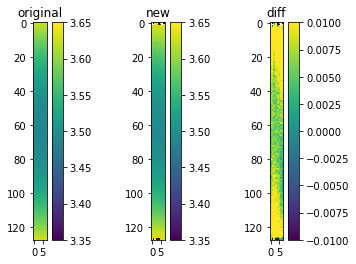

In [30]:
pack = 10

plt.figure()
sl = slice(pack*1024, (pack+1)*1024)
view = L2_arr[:, 2][sl].view()
view.shape = 8, 128
plt.subplot(1,3,1)
plt.title('original')
plt.imshow(view.T)
plt.clim(3.35, 3.65)
plt.colorbar()

view = L2_arr[:, 3][sl].view()
view.shape = 8, 128
plt.subplot(1,3,2)
plt.title('new')
plt.imshow(view.T)
plt.clim(3.35, 3.65)
plt.colorbar()


view = L2_arr[:, 3][sl]-L2_arr[:, 2][sl]
view.shape = 8, 128
plt.subplot(1,3,3)
plt.title('diff')
plt.imshow(view.T)
plt.clim(-.01, .01)
plt.colorbar()


# Save mantid ws

In [31]:
L2table = msa.CreateEmptyTableWorkspace()

In [32]:
%%time
L2table.addColumn(type='int', name='detid')
L2table.addColumn(type='float', name="L2")
L2table.addColumn(type='int', name="nodata")

for spectrumNo, pixelID, L2_0, L2, tot_counts in L2s:
    row = dict(detid=pixelID, L2=L2, nodata=int(L2<0))
    L2table.addRow(row)

CPU times: user 220 ms, sys: 44 ms, total: 264 ms
Wall time: 216 ms


In [33]:
msa.SaveNexus(L2table, 'L2table.nxs')